# Notebook 07: Proposal Order Amounts

This notebook generates sales orders for the 2022H3 proposal using forecasting and regression predictions generated in [Notebook 4: Forecasting Monthly](04_Forecasting_Monthly.ipynb) and [Notebook 6: Classification Predicting Sales For New Models](05_Classification_Predict_Sales.ipynb).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.metrics import mean_squared_error
import datetime
import math
    
from custom_functions import *
from regression_custom_functions import *

In [2]:
# Import datasets and predictions
df_proposal = pd.read_csv('../data/cleaned_datasets/df_models.csv')
proposal_predictions = pd.read_csv('../data/predictions/proposal_forecast.csv')
new_model_predictions = pd.read_csv('../data/predictions/new_models_classifications.csv')

# Drop items not on proposal
df_proposal.dropna(subset='proposal_priority',inplace=True)

# Get names of columns for predictions
proposal_preds_column = proposal_predictions.columns[1]
new_model_preds_column = new_model_predictions.columns[1]

## Create new dataframe that merges proposal, proposal forecast, new models, and new model predictions to create an overall order.

In [3]:
# Create new data frame for the order sheet (there is some extra columns that will be dropped later)
order_sheet_columns = ['style_id','proposal_priority', 'retail_price','gender',
                       'collection','case_size','availability', 
                       'qty_on_hand','qty_on_order','qty_total_inv','planned_order',
                       'qty_sold_last_6m','qty_avg/mo','wholesale_price','xyz_cost']
order_sheet = df_proposal[order_sheet_columns]

# Merge proposal and new model predictions
order_sheet = order_sheet.merge(proposal_predictions, how = 'left', on = 'style_id')
order_sheet = order_sheet.merge(new_model_predictions, how = 'left', on = 'style_id')

# Convert predictions to an order quantity
preds_to_order(order_sheet, 5, 10) # see custom_functions for more information about how these are calculated

## Calculate other values important to XYZ

In [4]:
# Calculate the total units sold in the last 6 months
last_month_sales = '2022-04' # change as needed

In [5]:
total_qty_on_order = order_sheet.qty_on_order.sum()
total_qty_on_order

1890.0

In [6]:
total_qty_on_hand = order_sheet.qty_on_hand.sum()
total_qty_on_hand

6102.0

In [8]:
# Calculate total sales in the last 6 months
sales_rolling_6m = return_sales(df_proposal,'style_id').rolling(6)
qty_sold_last_6m_calc = sales_rolling_6m.sum().T[[last_month_sales]]
qty_sold_last_6m_calc.columns = ['qty_sold_last_6m_calc']
order_sheet = order_sheet.merge(qty_sold_last_6m_calc, how = 'left', on = 'style_id')
total_qty_sold_last_6m = round(order_sheet.qty_sold_last_6m_calc.sum())
total_qty_sold_last_6m

5815

In [9]:
# Calculate Average/month in last 6 months
qty_avg_mo_calc = sales_rolling_6m.mean().T[[last_month_sales]]
qty_avg_mo_calc.columns = ['qty_avg/mo_calc']
order_sheet = order_sheet.merge(qty_avg_mo_calc, how = 'left', on = 'style_id')

In [10]:
# Calculate months of supply with order
order_sheet['months_of_supply_raw_calc'] = (order_sheet['qty_total_inv'] + order_sheet['order_quantity']) / order_sheet['qty_avg/mo_calc']
order_sheet.months_of_supply_raw_calc = order_sheet.months_of_supply_raw_calc.astype(str).replace('inf',np.nan).replace('nan',np.nan).astype(float)

In [11]:
order_sheet[order_sheet.months_of_supply_raw_calc < 3]

,style_id,proposal_priority,retail_price,gender,collection,case_size,availability,qty_on_hand,qty_on_order,qty_total_inv,...,qty_avg/mo,wholesale_price,xyz_cost,monthly_forecast_Q3,monthly_classifications_Q3,quarterly_forecast,order_quantity,qty_sold_last_6m_calc,qty_avg/mo_calc,months_of_supply_raw_calc
2,ce1111,c,230.0,ladies,fb-01,36.0,available,0.0,0.0,0.0,...,0.833333,115.0,80.50,0.0,NaN,0,0,4.0,0.666667,0.0
181,fs5846,c,99.0,mens,retrodigital,40.0,delivery more than 6 weeks,0.0,0.0,0.0,...,0.000000,49.5,34.65,0.0,NaN,0,0,1.0,0.166667,0.0


There are some models where the units sold in the last 6 months are so low (<1/month) that the model forecasts for the order quantity to be 0. 

In [12]:
# Calculate cost of the order
proposal_cost = round((order_sheet.xyz_cost*order_sheet.order_quantity).sum())
print(f'${proposal_cost}')

$56205


In [13]:
order_sheet.columns

Index(['style_id', 'proposal_priority', 'retail_price', 'gender', 'collection',
       'case_size', 'availability', 'qty_on_hand', 'qty_on_order',
       'qty_total_inv', 'planned_order', 'qty_sold_last_6m', 'qty_avg/mo',
       'wholesale_price', 'xyz_cost', 'monthly_forecast_Q3',
       'monthly_classifications_Q3', 'quarterly_forecast', 'order_quantity',
       'qty_sold_last_6m_calc', 'qty_avg/mo_calc',
       'months_of_supply_raw_calc'],
      dtype='object')

In [14]:
# Rearrange and drop unnecessary columns
order_sheet_save = order_sheet[['style_id', 'retail_price', 'collection', 'qty_on_hand',
       'qty_on_order', 'qty_total_inv', 'qty_sold_last_6m', 'qty_sold_last_6m_calc',
       'qty_avg/mo', 'qty_avg/mo_calc','wholesale_price', 'xyz_cost', 'quarterly_forecast', 'planned_order', 'order_quantity']]

# Change to int
order_sheet_save[['qty_on_hand', 'qty_on_order',
       'qty_total_inv', 'qty_sold_last_6m', 'qty_sold_last_6m_calc','planned_order']] = order_sheet_save[['qty_on_hand', 'qty_on_order',
       'qty_total_inv', 'qty_sold_last_6m', 'qty_sold_last_6m_calc','planned_order']].astype(int)

# Round
order_sheet_save[['qty_avg/mo','qty_avg/mo_calc','xyz_cost']] = round(order_sheet_save[['qty_avg/mo','qty_avg/mo_calc','xyz_cost']],2)

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_41263/645371206.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_sheet_save[['qty_on_hand', 'qty_on_order',
/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_41263/645371206.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_sheet_save[['qty_avg/mo','qty_avg/mo_calc','xyz_cost']] = round(order_sheet_save[['qty_avg/mo','qty_avg/mo_calc','xyz_cost']],2)


In [15]:
order_sheet_save.to_csv('../output/order_sheet.csv',index=False)

## Discussion

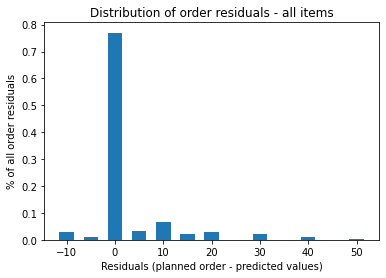

In [16]:
# Compare order to the planned order provided by XYZ
order_sheet['residuals'] = order_sheet.planned_order - order_sheet.order_quantity
residuals_counts = pd.DataFrame(order_sheet.residuals.value_counts(normalize=True)).sort_index()

plt.bar(residuals_counts.index.values, residuals_counts.residuals,width=3)
plt.title('Distribution of order residuals - all items')
plt.xlabel('Residuals (planned order - predicted values)')
plt.ylabel('% of all order residuals');

In [17]:
print(f'Of the {order_sheet.shape[0]} items on the proposal, {round(residuals_counts.loc[0,"residuals"]*100)}% of orders were identical to the planned order.')
print(f'{round(residuals_counts.loc[-10:10,"residuals"].sum()*100)}% were within +/- 10 units.')
print(f'There were {new_model_predictions.shape[0]} new models and {proposal_predictions.shape[0]} existing models on the proposal.') 

Of the 300 items on the proposal, 77% of orders were identical to the planned order.
91% were within +/- 10 units.
There were 35 new models and 265 existing models on the proposal.


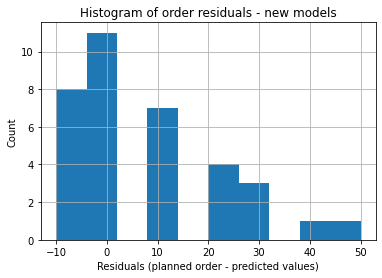

In [18]:
order_sheet[order_sheet[proposal_preds_column].astype(str) == "nan"].residuals.hist()
plt.title('Histogram of order residuals - new models')
plt.xlabel('Residuals (planned order - predicted values)')
plt.ylabel('Count');

/Applications/anaconda3/lib/python3.8/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in true_divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


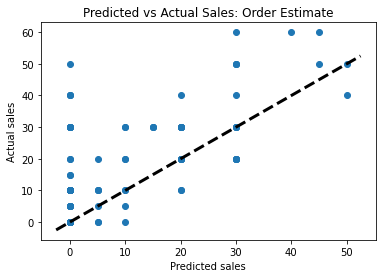

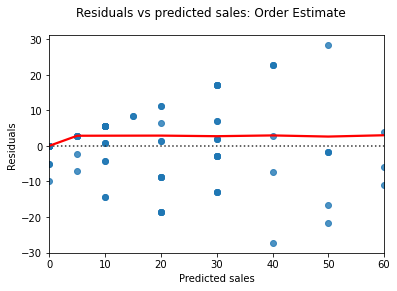

In [19]:
plot_preds(order_sheet['planned_order'], order_sheet['order_quantity'], 'Order Estimate')

The predicted sales versus the actual sales generally followed a linear trend, and the residuals are linear across the y axis. However, the error becomes much larger as predicted sales increases, indicating that model does not predict large sales well. However, this makes up a minority of models (typically only new models). This is an improvement area.

In [20]:
rmse = mean_squared_error(order_sheet['planned_order'],order_sheet['order_quantity'],squared=False)
mean_planned = order_sheet['planned_order'].mean()
mean_preds = order_sheet['order_quantity'].mean()

print(f"The root mean squared error of the orders is {round(rmse,2)} units.")
print(f"The mean of the planned orders is {round(mean_planned,2)} units.")
print(f"The mean of the predicted orders is {round(mean_preds,2)} units.")

The root mean squared error of the orders is 8.56 units.
The mean of the planned orders is 6.33 units.
The mean of the predicted orders is 3.63 units.


## Conclusion

XYZ Company can use this code to generate an initial pass on generating forecastings for this brand's proposals. It is nimble enough to take next quarter's proposal with new models and generate new predictions. While the predictions are not very accurate, they are typically +/- 10 units and can serve as an easy way to generate a quick order sheet. The business should note the limitations and note that the predictions are "conservative" - they may want to adjust order quantities up.

## Next Steps

Future work includes the following:
- Evaluate using a shorter rolling average (upon approval from the business) to allow the forecast to become more responsive to shifts in sales
- To increase bias, further consolidate values in categories, for example:  colors, materials, collections
- Develop a script or app to allow more user-friendly use of the models

Recommendations for XYZ Company:
- To continue this type of work, it would be highly benifical to improve data systems so that monthly sales are stored in historical data. This would allow for more sophisticated techniques, like SARIMA.